In [1]:
# ========================= Cell 1: Imports & Config =========================
import os
import numpy as np
import pandas as pd
import torch
import timm
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths to clean labels CSV and validation split
LABELS_CSV = "labels_clean.csv"          # same file you created during training
VAL_SPLIT  = "val_split.txt"             # validation split file
IMG_DIR    = "data"                      # root data folder

# Checkpoint paths (update to your files!)
DENSENET_CKPT = "checkpoints_densenet/best_model_auroc.pth"
EFFB3_CKPT    = "checkpoints_efficientnet_b3/best_model_auroc.pth"
EFFB4_CKPT    = "checkpoints_efficientnet_b4/best_model_auroc_b4.pth"

# Class names
class_names = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

# Validation transforms
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


Using device: cuda


In [2]:
# ========================= Cell 2: Dataset =========================
class ChestXrayDataset(Dataset):
    def __init__(self, file_list, img_dir, labels_csv, img_size=224, transform=None):
        self.img_paths = []
        self.labels = []

        df = pd.read_csv(labels_csv)
        label_dict = dict(zip(df['Image Index'], df.drop(columns=['Image Index']).values.tolist()))

        with open(file_list, "r") as f:
            for line in f:
                fname = line.strip().split()[0]
                if fname not in label_dict:
                    continue
                found_path = None
                for subdir in os.listdir(img_dir):
                    subpath = os.path.join(img_dir, subdir, "images", fname)
                    if os.path.exists(subpath):
                        found_path = subpath
                        break
                if found_path is None:
                    continue
                self.img_paths.append(found_path)
                self.labels.append(label_dict[fname])

        self.labels = np.array(self.labels, dtype=np.float32)
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = np.stack([img, img, img], axis=-1)
        if self.transform:
            img = self.transform(image=img)["image"]
        else:
            img = torch.tensor(img/255.0, dtype=torch.float32).permute(2,0,1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label


In [3]:
# ========================= Cell 3: Validation Loader =========================
# Default to 380px because EfficientNet-B4 needs it. We will resize internally per model later if needed.
val_dataset = ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, img_size=380, transform=val_transform)
val_loader  = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

print(f"Validation set size: {len(val_dataset)}")



Validation set size: 8653


In [4]:
# ========================= Cell 4: Ensemble Inference & Metrics =========================

# Create dataloaders for each model with its own input size
val_dataset_dn  = ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, img_size=224, transform=val_transform)
val_loader_dn   = DataLoader(val_dataset_dn, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

val_dataset_b3  = ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, img_size=300, transform=val_transform)
val_loader_b3   = DataLoader(val_dataset_b3, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

val_dataset_b4  = ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, img_size=380, transform=val_transform)
val_loader_b4   = DataLoader(val_dataset_b4, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# Load models
def load_model(arch, ckpt_path):
    model = timm.create_model(arch, pretrained=False, num_classes=14)
    checkpoint = torch.load(ckpt_path, map_location=device)

    # Handle full checkpoint dicts
    if "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint

    # Fix: remove "backbone." prefix if present
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace("backbone.", "") if k.startswith("backbone.") else k
        new_state_dict[new_key] = v

    model.load_state_dict(new_state_dict, strict=False)  # strict=False avoids leftover mismatches
    model = model.to(device)
    model.eval()
    return model



model_dn  = load_model("densenet121", DENSENET_CKPT)
model_b3  = load_model("efficientnet_b3", EFFB3_CKPT)
model_b4  = load_model("efficientnet_b4", EFFB4_CKPT)

# Inference helper
def get_logits(model, loader):
    logits_list, targets_list = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Infer {model.__class__.__name__}", leave=False):
            imgs = imgs.to(device)
            out = model(imgs)
            logits_list.append(out.cpu().numpy())
            targets_list.append(labels.numpy())
    return np.vstack(logits_list), np.vstack(targets_list)

logits_dn, y_true_dn = get_logits(model_dn, val_loader_dn)
logits_b3, y_true_b3 = get_logits(model_b3, val_loader_b3)
logits_b4, y_true_b4 = get_logits(model_b4, val_loader_b4)

# sanity check: labels must match
assert np.array_equal(y_true_dn, y_true_b3) and np.array_equal(y_true_dn, y_true_b4)
y_true = y_true_dn

# Compute AUROC for individual models
def compute_macro_auc(y_true, logits, name):
    probs = 1 / (1 + np.exp(-logits))
    aucs = []
    for c in range(y_true.shape[1]):
        try:
            aucs.append(roc_auc_score(y_true[:,c], probs[:,c]))
        except:
            aucs.append(np.nan)
    print(f"{name}: Macro AUROC={np.nanmean(aucs):.4f}")
    return np.nanmean(aucs)

auc_dn = compute_macro_auc(y_true, logits_dn, "DenseNet121")
auc_b3 = compute_macro_auc(y_true, logits_b3, "EfficientNet-B3")
auc_b4 = compute_macro_auc(y_true, logits_b4, "EfficientNet-B4")

# ---- Ensemble (simple average + weighted average) ----
ens_logits_avg = (logits_dn + logits_b3 + logits_b4) / 3.0
ens_probs_avg = 1 / (1 + np.exp(-ens_logits_avg))

wa, wb, wc = auc_dn, auc_b3, auc_b4
s = wa + wb + wc + 1e-12
wa, wb, wc = wa/s, wb/s, wc/s
ens_logits_w = logits_dn*wa + logits_b3*wb + logits_b4*wc
ens_probs_w = 1 / (1 + np.exp(-ens_logits_w))

# ---- Threshold tuning ----
def tune_thresholds(y_true, probs):
    best_thresh = []
    for c in range(y_true.shape[1]):
        best_f, best_t = -1, 0.5
        for t in np.linspace(0.05, 0.95, 19):
            f = f1_score(y_true[:,c], (probs[:,c] >= t).astype(int), zero_division=0)
            if f > best_f:
                best_f, best_t = f, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

th_avg = tune_thresholds(y_true, ens_probs_avg)
th_w   = tune_thresholds(y_true, ens_probs_w)

# ---- Final evaluation ----
def eval_with_thresholds(y_true, probs, thresholds, name):
    preds = (probs >= thresholds).astype(int)
    macro_f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    micro_f1 = f1_score(y_true, preds, average='micro', zero_division=0)
    macro_auc = roc_auc_score(y_true, probs, average='macro')
    print(f"{name}: Macro AUROC={macro_auc:.4f}, Macro-F1={macro_f1:.4f}, Micro-F1={micro_f1:.4f}")
    return macro_auc, macro_f1, micro_f1

print("\n=== Ensemble Results ===")
auc_avg, f1_avg, micro_f1_avg = eval_with_thresholds(y_true, ens_probs_avg, th_avg, "Simple Avg Ensemble")
auc_w, f1_w, micro_f1_w = eval_with_thresholds(y_true, ens_probs_w, th_w, "Weighted Ensemble")

# ---- Per-class breakdown (weighted ensemble) ----
per_class = []
print("\n--- Per-class results (Weighted Ensemble) ---")
for c, name in enumerate(class_names):
    y_true_c = y_true[:,c]
    y_prob_c = ens_probs_w[:,c]
    y_pred_c = (y_prob_c >= th_w[c]).astype(int)
    try: auroc = roc_auc_score(y_true_c, y_prob_c)
    except: auroc = np.nan
    try: auprc = average_precision_score(y_true_c, y_prob_c)
    except: auprc = np.nan
    f1c = f1_score(y_true_c, y_pred_c, zero_division=0)
    per_class.append((name, th_w[c], auroc, auprc, f1c))
    print(f"{name:<20} | Thresh={th_w[c]:.2f} | AUROC={auroc:.3f} | AUPRC={auprc:.3f} | F1={f1c:.3f}")

# Save results as DataFrame + CSV
df = pd.DataFrame(per_class, columns=["Disease","Best_Thresh","AUROC","AUPRC","F1"])
os.makedirs("ensemble_results", exist_ok=True)
df.to_csv("ensemble_results/ensemble_metrics.csv", index=False)
print("\n✅ Saved per-class metrics to ensemble_results/ensemble_metrics.csv")


/tmp/ipykernel_1683/1348986975.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


DenseNet121: Macro AUROC=0.8357
EfficientNet-B3: Macro AUROC=0.7545
EfficientNet-B4: Macro AUROC=0.7627

=== Ensemble Results ===
Simple Avg Ensemble: Macro AUROC=0.8249, Macro-F1=0.3257, Micro-F1=0.3671
Weighted Ensemble: Macro AUROC=0.8267, Macro-F1=0.3255, Micro-F1=0.3576

--- Per-class results (Weighted Ensemble) ---
Atelectasis          | Thresh=0.45 | AUROC=0.828 | AUPRC=0.363 | F1=0.416
Cardiomegaly         | Thresh=0.65 | AUROC=0.893 | AUPRC=0.244 | F1=0.337
Effusion             | Thresh=0.45 | AUROC=0.902 | AUPRC=0.547 | F1=0.554
Infiltration         | Thresh=0.40 | AUROC=0.682 | AUPRC=0.291 | F1=0.343
Mass                 | Thresh=0.45 | AUROC=0.844 | AUPRC=0.318 | F1=0.382
Nodule               | Thresh=0.40 | AUROC=0.728 | AUPRC=0.221 | F1=0.305
Pneumonia            | Thresh=0.25 | AUROC=0.707 | AUPRC=0.031 | F1=0.080
Pneumothorax         | Thresh=0.50 | AUROC=0.893 | AUPRC=0.302 | F1=0.364
Consolidation        | Thresh=0.45 | AUROC=0.799 | AUPRC=0.151 | F1=0.238
Edema      

In [16]:
# ========================= DenseNet Evaluation =========================
import numpy as np
import torch
import timm
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Path to DenseNet checkpoint
DENSENET_CKPT = "checkpoints_densenet/best_model_auroc.pth"

# Class names
class_names = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load DenseNet checkpoint ----
def load_densenet(ckpt_path):
    model = timm.create_model("densenet121", pretrained=False, num_classes=14)
    checkpoint = torch.load(ckpt_path, map_location=device)

    # Handle case where checkpoint is dict with model_state_dict
    if "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint

    # Strip "backbone." prefix if present
    new_state = {}
    for k, v in state_dict.items():
        new_key = k.replace("backbone.", "") if k.startswith("backbone.") else k
        new_state[new_key] = v

    model.load_state_dict(new_state, strict=False)
    model.to(device)
    model.eval()
    return model

model_dn = load_densenet(DENSENET_CKPT)

# ---- Inference ----
def get_logits(model, loader):
    logits_list, targets_list = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Infer DenseNet", leave=False):
            imgs = imgs.to(device)
            out = model(imgs)
            logits_list.append(out.cpu().numpy())
            targets_list.append(labels.numpy())
    return np.vstack(logits_list), np.vstack(targets_list)

logits_dn, y_true = get_logits(model_dn, val_loader_dn)  # use 224px loader

# ---- Threshold tuning ----
def tune_thresholds(y_true, probs):
    best_thresh = []
    for c in range(y_true.shape[1]):
        best_f, best_t = -1, 0.5
        for t in np.linspace(0.05, 0.95, 19):
            f = f1_score(y_true[:,c], (probs[:,c] >= t).astype(int), zero_division=0)
            if f > best_f:
                best_f, best_t = f, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

# ---- Compute metrics ----
probs_dn = 1 / (1 + np.exp(-logits_dn))
thresh_dn = tune_thresholds(y_true, probs_dn)

preds = (probs_dn >= thresh_dn).astype(int)
macro_f1 = f1_score(y_true, preds, average='macro', zero_division=0)
micro_f1 = f1_score(y_true, preds, average='micro', zero_division=0)
macro_auc = roc_auc_score(y_true, probs_dn, average='macro')

print("\n=== DenseNet Results ===")
print(f"Macro AUROC={macro_auc:.4f}, Macro-F1={macro_f1:.4f}, Micro-F1={micro_f1:.4f}")

# ---- Per-class metrics ----
print("\n--- Per-class Results (DenseNet) ---")
for c, name in enumerate(class_names):
    y_true_c = y_true[:,c]
    y_prob_c = probs_dn[:,c]
    y_pred_c = preds[:,c]
    try: auroc = roc_auc_score(y_true_c, y_prob_c)
    except: auroc = np.nan
    try: auprc = average_precision_score(y_true_c, y_prob_c)
    except: auprc = np.nan
    f1c = f1_score(y_true_c, y_pred_c, zero_division=0)
    print(f"{name:<20} | Thresh={thresh_dn[c]:.2f} | AUROC={auroc:.3f} | AUPRC={auprc:.3f} | F1={f1c:.3f}")


/tmp/ipykernel_1495/670781936.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)



=== DenseNet Results ===
Macro AUROC=0.8357, Macro-F1=0.3084, Micro-F1=0.3669

--- Per-class Results (DenseNet) ---
Atelectasis          | Thresh=0.15 | AUROC=0.832 | AUPRC=0.374 | F1=0.419
Cardiomegaly         | Thresh=0.20 | AUROC=0.895 | AUPRC=0.273 | F1=0.333
Effusion             | Thresh=0.25 | AUROC=0.902 | AUPRC=0.547 | F1=0.563
Infiltration         | Thresh=0.30 | AUROC=0.684 | AUPRC=0.286 | F1=0.351
Mass                 | Thresh=0.15 | AUROC=0.843 | AUPRC=0.334 | F1=0.407
Nodule               | Thresh=0.10 | AUROC=0.758 | AUPRC=0.225 | F1=0.296
Pneumonia            | Thresh=0.05 | AUROC=0.775 | AUPRC=0.046 | F1=0.081
Pneumothorax         | Thresh=0.15 | AUROC=0.869 | AUPRC=0.301 | F1=0.363
Consolidation        | Thresh=0.10 | AUROC=0.824 | AUPRC=0.170 | F1=0.249
Edema                | Thresh=0.10 | AUROC=0.894 | AUPRC=0.166 | F1=0.233
Emphysema            | Thresh=0.10 | AUROC=0.903 | AUPRC=0.297 | F1=0.378
Fibrosis             | Thresh=0.05 | AUROC=0.804 | AUPRC=0.103 | F1=0

In [17]:
import numpy as np

# Assume you have models: densenet, effnet_b3, effnet_b4
# Assume val_loader is defined
# Classes list
all_labels = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

def get_model_outputs(model, loader, device="cuda"):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.append(probs)
            targets.append(lbls.cpu().numpy())
    return np.vstack(preds), np.vstack(targets)

# Get predictions from each model
# Use existing logits from your notebook
preds_dn, y_true = 1 / (1 + np.exp(-logits_dn)), y_true_dn
preds_b3, _ = 1 / (1 + np.exp(-logits_b3)), y_true_b3
preds_b4, _ = 1 / (1 + np.exp(-logits_b4)), y_true_b4

print("Shapes:", preds_dn.shape, preds_b3.shape, preds_b4.shape, "Labels:", y_true.shape)





Shapes: (8653, 14) (8653, 14) (8653, 14) Labels: (8653, 14)


In [18]:
# Stack predictions into meta-learning input
# Shape will be (N_samples, 14, 3)
X_meta = np.stack([preds_dn, preds_b3, preds_b4], axis=-1)
print("Stacked feature shape:", X_meta.shape)  # (num_samples, 14 classes, 3 models)


Stacked feature shape: (8653, 14, 3)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

meta_models = []
all_results = {}

for c, cls in enumerate(class_names):
    X_c = X_meta[:, c, :]   # features for class c (DenseNet, B3, B4)
    y_c = y_true[:, c]      # true labels
    
    # Train logistic regression as meta-learner
    meta = LogisticRegression(max_iter=1000)
    meta.fit(X_c, y_c)
    meta_models.append(meta)
    
    # Predict probs for class c
    probs = meta.predict_proba(X_c)[:, 1]
    
    # Metrics
    auc   = roc_auc_score(y_c, probs)
    auprc = average_precision_score(y_c, probs)
    
    # Find best F1 threshold
    best_f1, best_t = 0, 0.5
    for t in np.linspace(0.05, 0.95, 50):
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_c, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    
    all_results[cls] = {"AUROC": auc, "AUPRC": auprc, "Best_F1": best_f1, "Thresh": best_t}

print("✅ Trained per-class meta-learners")


✅ Trained per-class meta-learners


In [20]:
import pandas as pd

# Create results table
df_results = pd.DataFrame(all_results).T
df_results = df_results[["AUROC","AUPRC","Best_F1","Thresh"]]
df_results.loc["Macro"] = df_results.mean(numeric_only=True)
display(df_results)

# Compute Micro-F1 across all classes
y_pred_meta = []
for c, cls in enumerate(class_names):
    probs = meta_models[c].predict_proba(X_meta[:, c, :])[:, 1]
    preds = (probs >= all_results[cls]["Thresh"]).astype(int)
    y_pred_meta.append(preds)

y_pred_meta = np.array(y_pred_meta).T
micro_f1 = f1_score(y_true.ravel(), y_pred_meta.ravel(), zero_division=0)

print("\n=== Stacked Ensemble Results ===")
print(f"Macro AUROC: {df_results.loc['Macro','AUROC']:.4f}")
print(f"Macro F1:    {df_results.loc['Macro','Best_F1']:.4f}")
print(f"Micro F1:    {micro_f1:.4f}")


,AUROC,AUPRC,Best_F1,Thresh
Atelectasis,0.818105,0.374762,0.426087,0.178571
Cardiomegaly,0.873982,0.264120,0.347619,0.123469
Effusion,0.896241,0.546963,0.565331,0.233673
Infiltration,0.691035,0.294611,0.350241,0.196939
Mass,0.820054,0.327756,0.409692,0.086735
Nodule,0.709400,0.219102,0.297321,0.068367
Pneumonia,0.632862,0.021953,0.000000,0.500000
Pneumothorax,0.878413,0.317966,0.383142,0.160204
Consolidation,0.787014,0.165015,0.255416,0.086735
Edema,0.884247,0.176512,0.252941,0.105102



=== Stacked Ensemble Results ===
Macro AUROC: 0.8070
Macro F1:    0.3163
Micro F1:    0.3759


In [21]:
from itertools import product
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

all_results_w = {}
best_weights = {}

for c, cls in enumerate(class_names):
    y_c = y_true[:, c]
    p_dn = preds_dn[:, c]
    p_b3 = preds_b3[:, c]
    p_b4 = preds_b4[:, c]
    
    if len(np.unique(y_c)) < 2:
        # Skip AUROC if only one class present
        all_results_w[cls] = {
            "AUROC": np.nan,
            "AUPRC": np.nan,
            "Best_F1": np.nan,
            "Thresh": np.nan,
            "Weights": (1.0, 0.0, 0.0)
        }
        continue
    
    # Grid search weights
    best_auc, best_w = -1, (1.0, 0.0, 0.0)
    for w1 in np.linspace(0,1,11):
        for w2 in np.linspace(0,1-w1,11):
            w3 = 1 - w1 - w2
            p_ens = w1*p_dn + w2*p_b3 + w3*p_b4
            try:
                auc = roc_auc_score(y_c, p_ens)
                if auc > best_auc:
                    best_auc = auc
                    best_w = (w1,w2,w3)
            except:
                continue
    
    # Final best prediction
    p_best = best_w[0]*p_dn + best_w[1]*p_b3 + best_w[2]*p_b4
    
    try:
        auroc = roc_auc_score(y_c, p_best)
    except:
        auroc = np.nan
    try:
        auprc = average_precision_score(y_c, p_best)
    except:
        auprc = np.nan
    
    # F1 tuning
    best_f1, best_t = 0, 0.5
    for t in np.linspace(0.05, 0.95, 19):
        preds = (p_best >= t).astype(int)
        f1 = f1_score(y_c, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    
    all_results_w[cls] = {
        "AUROC": auroc,
        "AUPRC": auprc,
        "Best_F1": best_f1,
        "Thresh": best_t,
        "Weights": best_w
    }
    best_weights[cls] = best_w

print("✅ Per-class weight search completed (NaNs handled)")


✅ Per-class weight search completed (NaNs handled)


In [22]:
# Create results DataFrame
df_results_w = pd.DataFrame(all_results_w).T
df_results_w = df_results_w[["AUROC","AUPRC","Best_F1","Thresh","Weights"]]

# Manually compute macro averages (ignore NaNs, ignore 'Weights')
macro_vals = {
    "AUROC": df_results_w["AUROC"].mean(skipna=True),
    "AUPRC": df_results_w["AUPRC"].mean(skipna=True),
    "Best_F1": df_results_w["Best_F1"].mean(skipna=True),
    "Thresh": df_results_w["Thresh"].mean(skipna=True),
    "Weights": "—"
}
df_results_w.loc["Macro"] = macro_vals

display(df_results_w)

# Micro F1 across all classes
y_pred_w = []
for c, cls in enumerate(class_names):
    if cls not in best_weights:  
        continue
    p_best = (best_weights[cls][0]*preds_dn[:,c] + 
              best_weights[cls][1]*preds_b3[:,c] + 
              best_weights[cls][2]*preds_b4[:,c])
    if np.isnan(all_results_w[cls]["Thresh"]):
        preds_c = np.zeros_like(y_true[:,c])  # fallback
    else:
        preds_c = (p_best >= all_results_w[cls]["Thresh"]).astype(int)
    y_pred_w.append(preds_c)

y_pred_w = np.array(y_pred_w).T
micro_f1_w = f1_score(y_true.ravel(), y_pred_w.ravel(), zero_division=0)

print("\n=== Per-class Weighted Ensemble Results ===")
print(f"Macro AUROC: {macro_vals['AUROC']:.4f}")
print(f"Macro F1:    {macro_vals['Best_F1']:.4f}")
print(f"Micro F1:    {micro_f1_w:.4f}")


,AUROC,AUPRC,Best_F1,Thresh,Weights
Atelectasis,0.835151,0.377554,0.418307,0.2,"(0.9, 0.05999999999999999, 0.03999999999999999)"
Cardiomegaly,0.895128,0.273353,0.333333,0.2,"(1.0, 0.0, 0.0)"
Effusion,0.903931,0.54958,0.560621,0.3,"(0.9, 0.039999999999999994, 0.059999999999999984)"
Infiltration,0.691198,0.294597,0.349144,0.35,"(0.6000000000000001, 0.27999999999999997, 0.11..."
Mass,0.84357,0.334901,0.400491,0.2,"(0.9, 0.08999999999999998, 0.009999999999999995)"
Nodule,0.758411,0.225446,0.296455,0.1,"(1.0, 0.0, 0.0)"
Pneumonia,0.775407,0.046442,0.080537,0.05,"(1.0, 0.0, 0.0)"
Pneumothorax,0.891186,0.315361,0.366667,0.25,"(0.9, 0.0, 0.09999999999999998)"
Consolidation,0.824463,0.170257,0.248521,0.1,"(1.0, 0.0, 0.0)"
Edema,0.894816,0.172739,0.237864,0.15,"(0.9, 0.06999999999999999, 0.029999999999999985)"



=== Per-class Weighted Ensemble Results ===
Macro AUROC: 0.8405
Macro F1:    0.3096
Micro F1:    0.3632


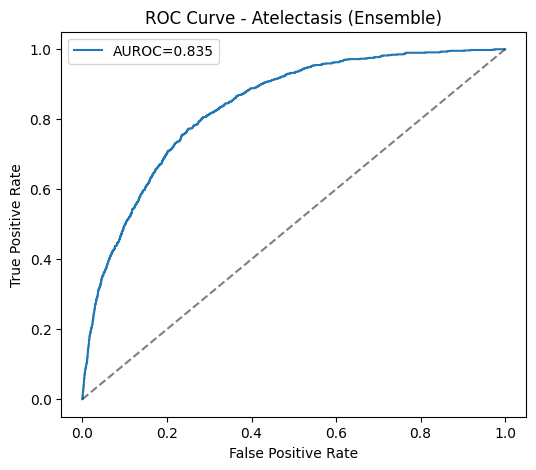

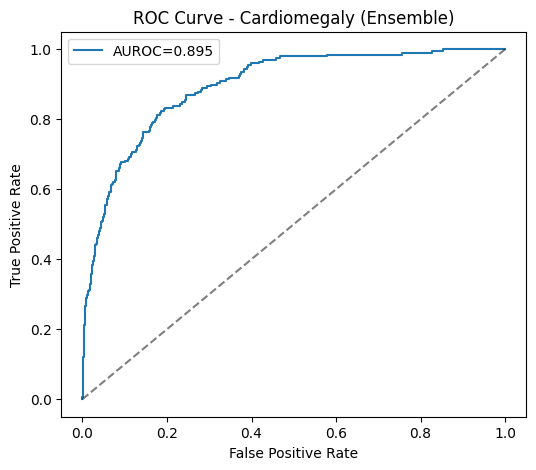

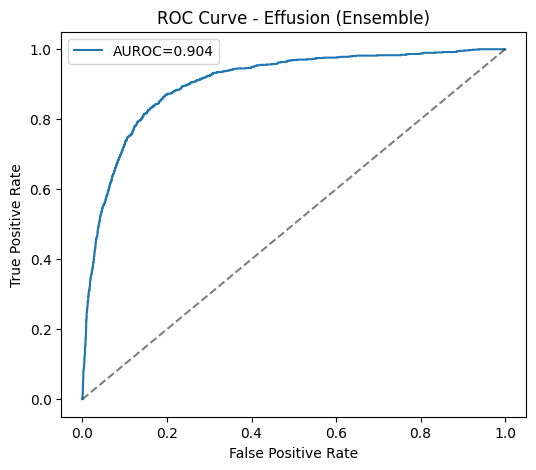

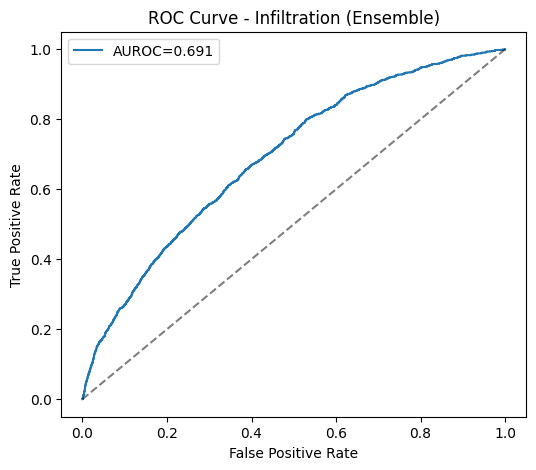

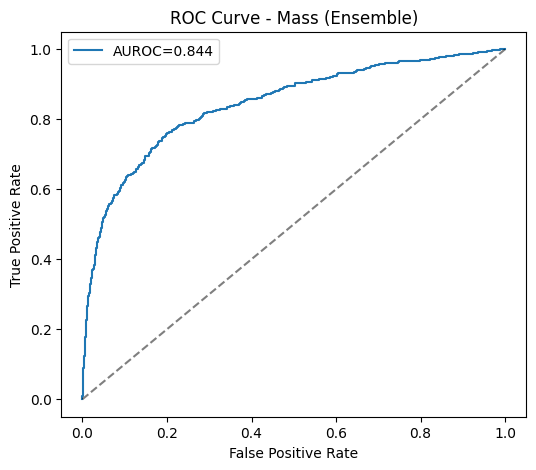

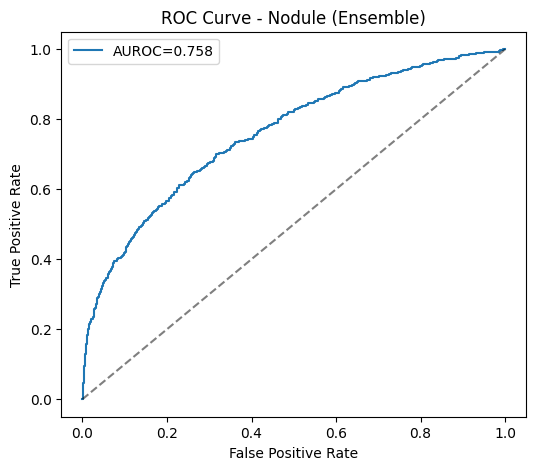

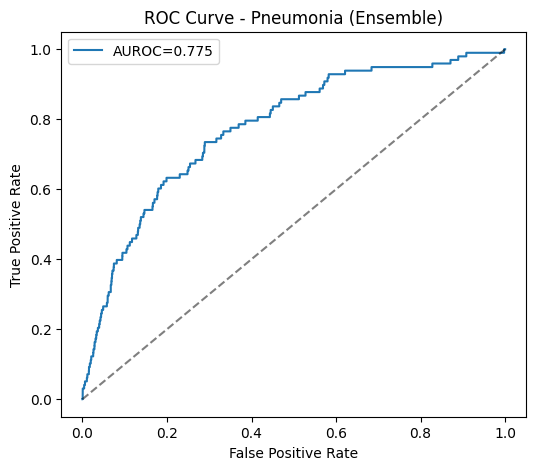

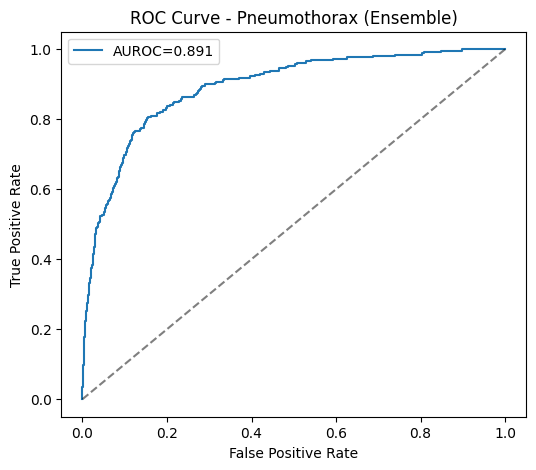

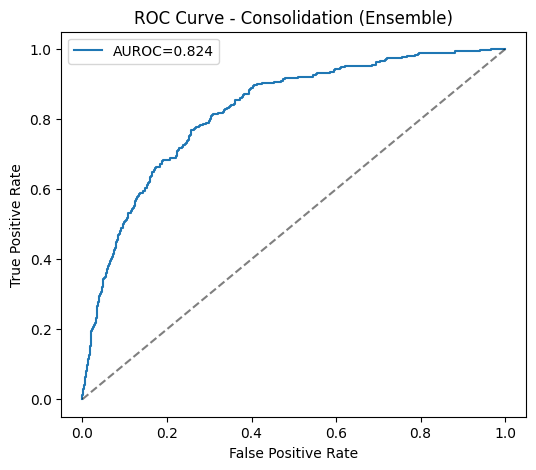

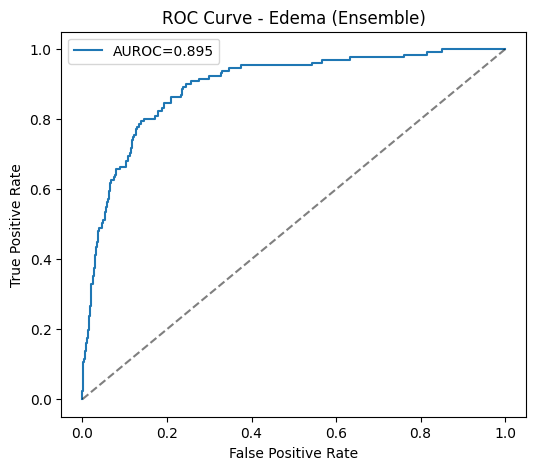

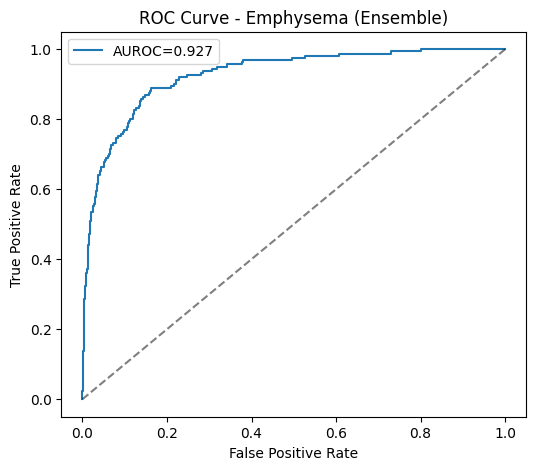

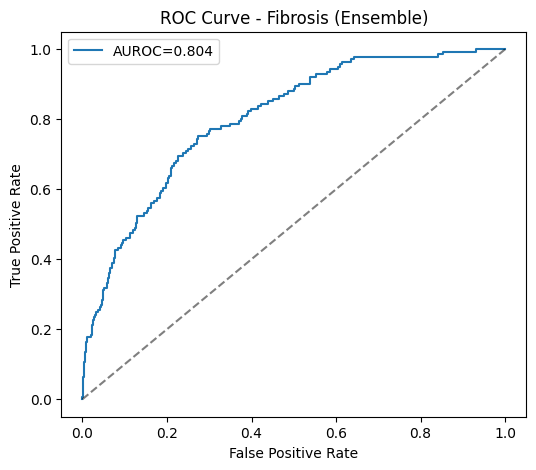

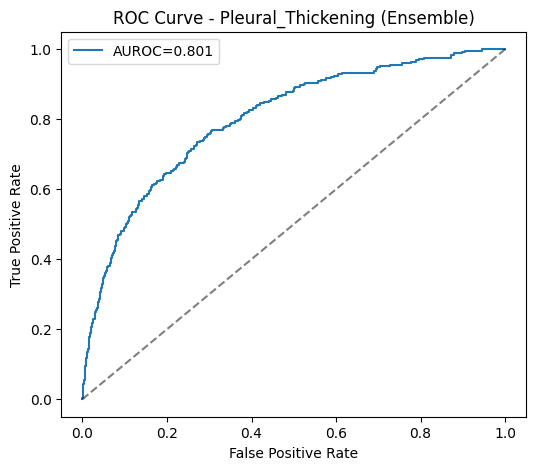

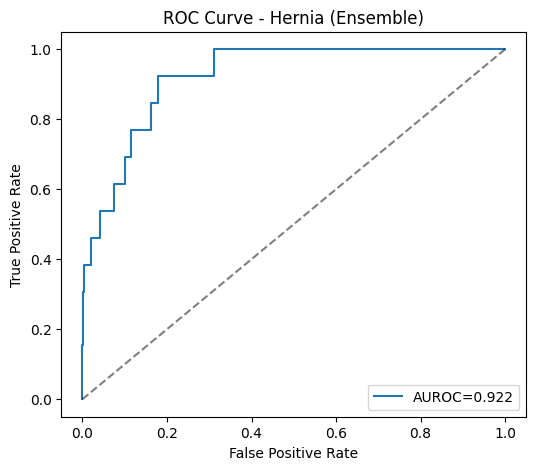

In [24]:
import matplotlib.pyplot as plt  # labels from DenseNet (same as B3/B4, already checked earlier)

from sklearn.metrics import roc_curve, roc_auc_score


for c, cls in enumerate(class_names):
    y_c = y_true[:, c]
    w_dn, w_b3, w_b4 = best_weights[cls]

    # Ensemble probability for this class
    p_ens = (w_dn * preds_dn[:,c] +
             w_b3 * preds_b3[:,c] +
             w_b4 * preds_b4[:,c])

    if len(np.unique(y_c)) < 2:
        print(f"Skipping {cls} (only one label present)")
        continue

    fpr, tpr, _ = roc_curve(y_c, p_ens)
    auc = roc_auc_score(y_c, p_ens)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUROC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {cls} (Ensemble)")
    plt.legend()
    plt.show()


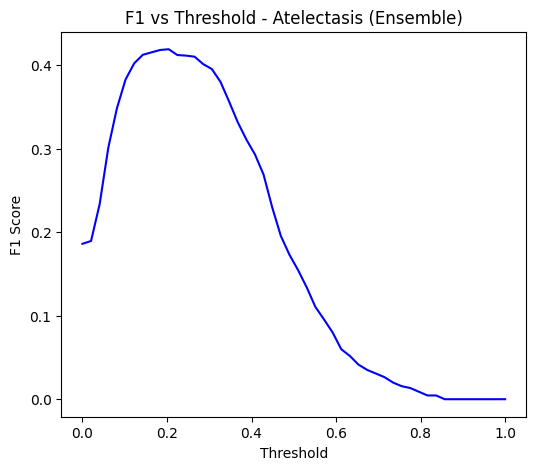

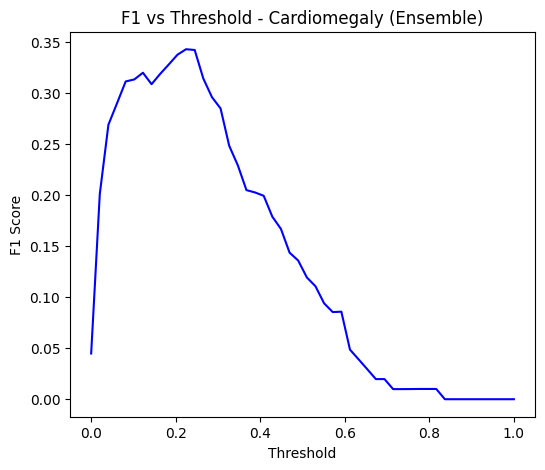

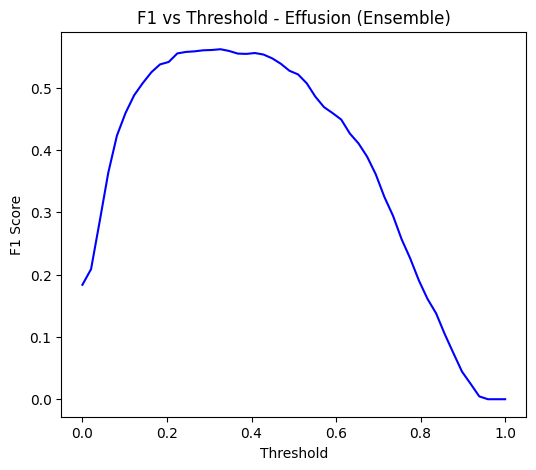

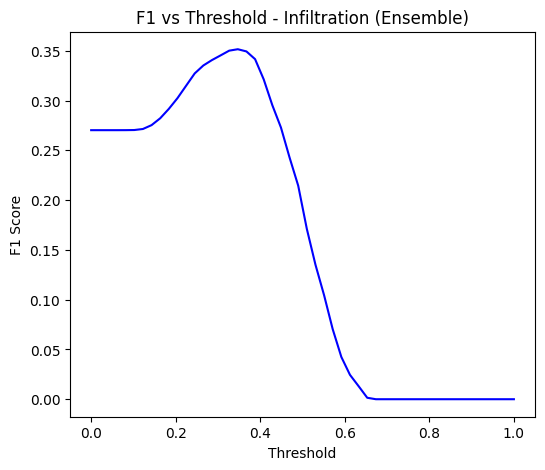

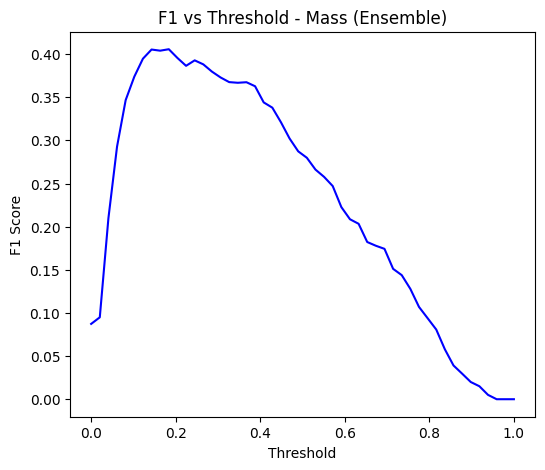

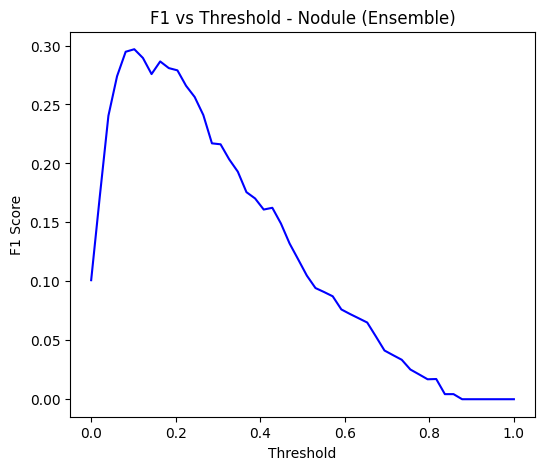

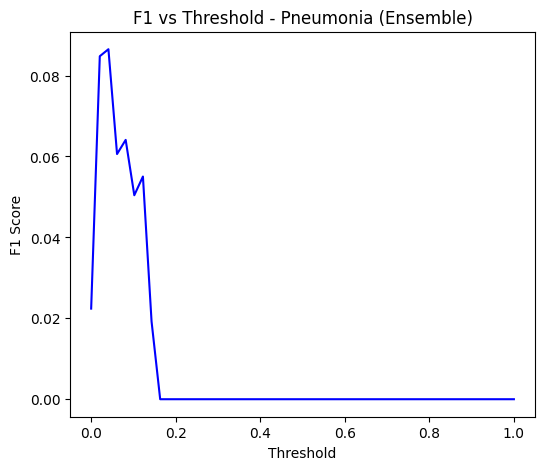

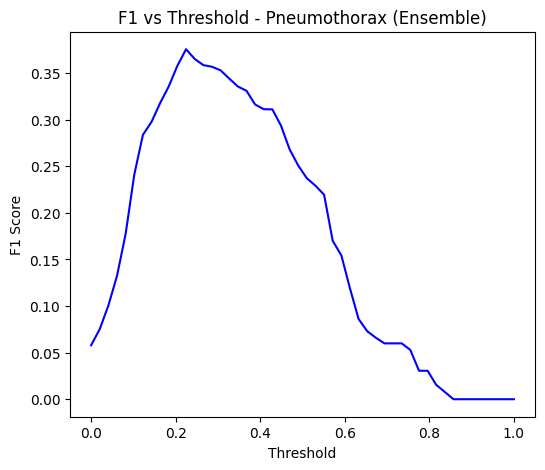

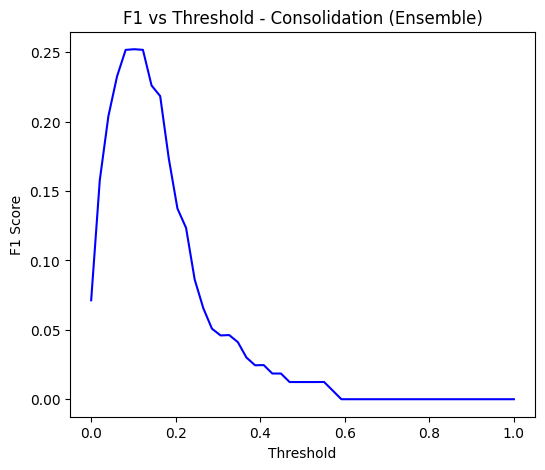

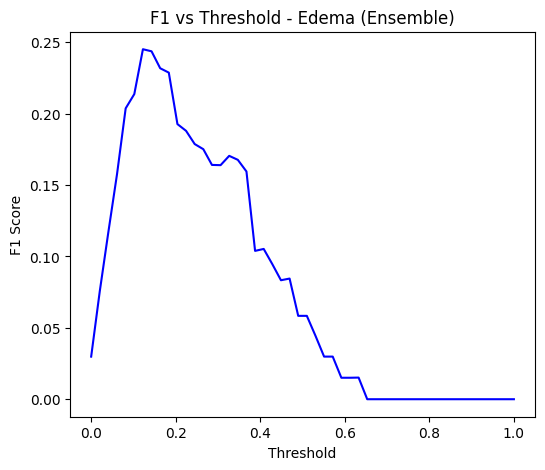

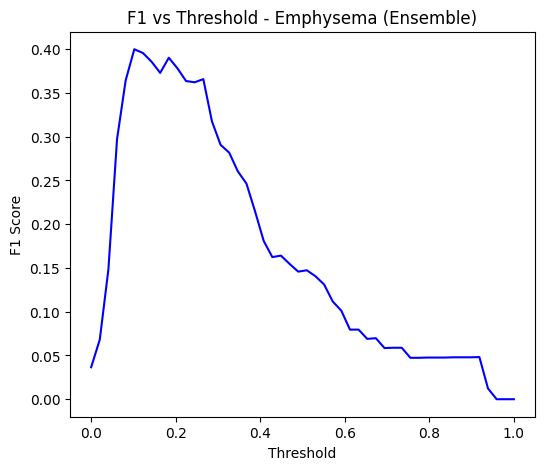

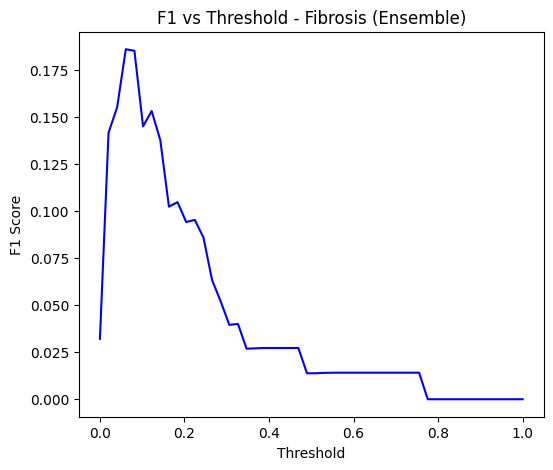

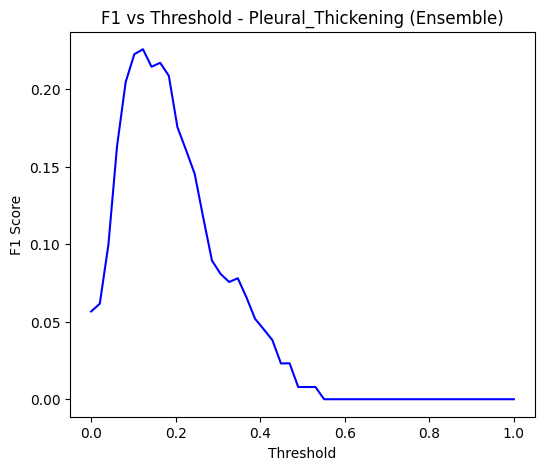

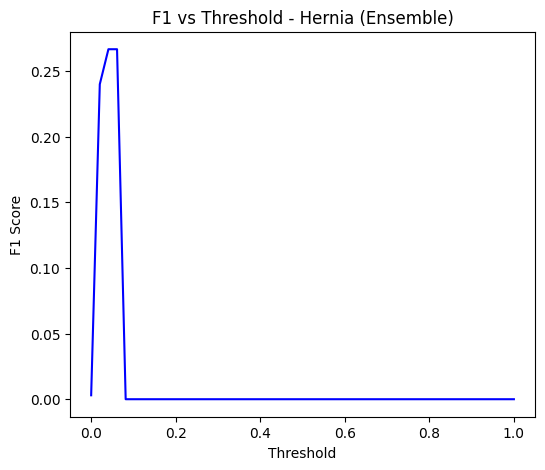

In [25]:
thresholds = np.linspace(0.0, 1.0, 50)

for c, cls in enumerate(class_names):
    y_c = y_true[:, c]
    w_dn, w_b3, w_b4 = best_weights[cls]

    # Ensemble probability
    p_ens = (w_dn * preds_dn[:,c] +
             w_b3 * preds_b3[:,c] +
             w_b4 * preds_b4[:,c])

    f1_vals = []
    for t in thresholds:
        preds = (p_ens >= t).astype(int)
        f1_vals.append(f1_score(y_c, preds, zero_division=0))

    plt.figure(figsize=(6,5))
    plt.plot(thresholds, f1_vals, color="blue")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"F1 vs Threshold - {cls} (Ensemble)")
    plt.show()


In [ ]:
import os
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Make output folders
os.makedirs("ensemble_curves/ROC", exist_ok=True)
os.makedirs("ensemble_curves/F1", exist_ok=True)

# Ensure labels exist
y_true = y_true_dn   # ground truth labels

thresholds = np.linspace(0.0, 1.0, 50)

for c, cls in enumerate(class_names):
    y_c = y_true[:, c]
    w_dn, w_b3, w_b4 = best_weights[cls]

    # Ensemble probability
    p_ens = (w_dn * preds_dn[:,c] +
             w_b3 * preds_b3[:,c] +
             w_b4 * preds_b4[:,c])

    if len(np.unique(y_c)) < 2:
        print(f"Skipping {cls} (only one label present)")
        continue

    # ==== ROC Curve ====
    fpr, tpr, _ = roc_curve(y_c, p_ens)
    auc = roc_auc_score(y_c, p_ens)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUROC={auc:.3f}", color="blue")
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {cls} (Ensemble)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"ensemble_curves/ROC/{cls}_ROC.png", dpi=150)
    plt.close()

    # ==== F1 vs Threshold Curve ====
    f1_vals = []
    for t in thresholds:
        preds = (p_ens >= t).astype(int)
        f1_vals.append(f1_score(y_c, preds, zero_division=0))

    plt.figure(figsize=(6,5checkpoints_densenet))
    plt.plot(thresholds, f1_vals, color="green")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"F1 vs Threshold - {cls} (Ensemble)")
    plt.tight_layout()
    plt.savefig(f"ensemble_curves/F1/{cls}_F1.png", dpi=150)
    plt.close()

print("✅ Saved ROC curves in: ensemble_curves/ROC/ and F1 curves in: ensemble_curves/F1/")


✅ Saved ROC curves in: ensemble_curves/ROC/ and F1 curves in: ensemble_curves/F1/


In [29]:
import os
import pandas as pd
import shutil

# Paths
CSV_PATH = "Data_Entry_2017.csv"       # adjust if CSV is in root
IMG_DIR = "data/images_001/images"          # your real images folder
OUT_DIR = "sample_per_class"
os.makedirs(OUT_DIR, exist_ok=True)

# Define the 14 classes
CLASSES = [
    "Atelectasis","Cardiomegaly","Effusion","Infiltration","Mass",
    "Nodule","Pneumonia","Pneumothorax","Consolidation","Edema",
    "Emphysema","Fibrosis","Pleural_Thickening","Hernia"
]

# Load metadata
df = pd.read_csv(CSV_PATH)

# Track which classes we already fetched
fetched = {cls: False for cls in CLASSES}

for _, row in df.iterrows():
    fname = row["Image Index"].strip()
    labels = row["Finding Labels"].split("|")
    
    for cls in labels:
        if cls in CLASSES and not fetched[cls]:
            src = os.path.join(IMG_DIR, fname)
            if os.path.exists(src):
                dst = os.path.join(OUT_DIR, f"{cls}_{fname}")
                shutil.copy(src, dst)
                fetched[cls] = True
                print(f"✅ Copied {fname} for {cls}")
    
    if all(fetched.values()):
        break

print("\nDone! One image per class saved in:", OUT_DIR)


✅ Copied 00000001_000.png for Cardiomegaly
✅ Copied 00000001_001.png for Emphysema
✅ Copied 00000001_002.png for Effusion
✅ Copied 00000003_000.png for Hernia
✅ Copied 00000003_003.png for Infiltration
✅ Copied 00000004_000.png for Mass
✅ Copied 00000004_000.png for Nodule
✅ Copied 00000011_006.png for Atelectasis
✅ Copied 00000013_001.png for Pneumothorax
✅ Copied 00000013_003.png for Pleural_Thickening
✅ Copied 00000013_010.png for Pneumonia
✅ Copied 00000020_001.png for Fibrosis
✅ Copied 00000032_001.png for Edema
✅ Copied 00000032_012.png for Consolidation

Done! One image per class saved in: sample_per_class


In [30]:
# --- ONE CELL: Grad-CAM + Faithfulness + RETURN METRICS (Final Version) ---

import os, cv2, torch, json
import numpy as np
import torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image

# =====================
# CONFIG
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "checkpoints/epoch_6.pth"     # <-- change if needed
SAVE_DIR   = "gradcam_outputs"

CLASS_NAMES = [
    "Atelectasis","Cardiomegaly","Effusion","Infiltration","Mass",
    "Nodule","Pneumonia","Pneumothorax","Consolidation","Edema",
    "Emphysema","Fibrosis","Pleural_Thickening","Hernia"
]

# Per-class thresholds for stable decisions
CLASS_THRESHOLDS = {
    "Atelectasis": 0.55,"Cardiomegaly": 0.50,"Effusion": 0.55,"Infiltration": 0.60,
    "Mass": 0.55,"Nodule": 0.60,"Pneumonia": 0.55,"Pneumothorax": 0.55,
    "Consolidation": 0.55,"Edema": 0.55,"Emphysema": 0.55,"Fibrosis": 0.55,
    "Pleural_Thickening": 0.55,"Hernia": 0.50
}

# =====================
# MODEL
# =====================
class CheXNet(nn.Module):
    def __init__(self, n_classes=14, pretrained=False):
        super().__init__()
        self.backbone = models.densenet121(pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, n_classes)
    def forward(self, x):
        return self.backbone(x)

def load_model():
    model = CheXNet(n_classes=len(CLASS_NAMES), pretrained=False)
    ckpt  = torch.load(MODEL_PATH, map_location=DEVICE)
    state = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
    clean = { (k[7:] if k.startswith("module.") else k): v for k,v in state.items() }
    model.load_state_dict(clean, strict=False)
    model.to(DEVICE).eval()
    return model

# =====================
# Grad-CAM
# =====================
class GradCAM:
    def __init__(self, target_layer: nn.Module):
        self.activations, self.gradients = None, None
        target_layer.register_forward_hook(self._fwd_hook)
        target_layer.register_full_backward_hook(self._bwd_hook)
    def _fwd_hook(self, m, i, o): self.activations = o
    def _bwd_hook(self, m, gi, go): self.gradients = go[0]
    def generate(self):
        if self.activations is None or self.gradients is None:
            raise RuntimeError("Grad-CAM not captured")
        w = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (w * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)[0,0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# =====================
# Preprocess
# =====================
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def tensor_to_img01(t):
    a = t.detach().cpu()
    a = (a - a.min()) / (a.max() - a.min() + 1e-8)
    return a.permute(1,2,0).numpy()

# =====================
# Predict + Explain
# =====================
def predict_image(img_path):
    os.makedirs(SAVE_DIR, exist_ok=True)
    model = load_model()
    target_layer = model.backbone.features.denseblock4
    cam = GradCAM(target_layer)

    pil = Image.open(img_path).convert("RGB")
    x = preprocess(pil).unsqueeze(0).to(DEVICE)
    logits = model(x)
    probs  = torch.sigmoid(logits)[0].detach().cpu().numpy()
    top3   = np.argsort(probs)[::-1][:3]
    orig   = np.array(pil.resize((224,224)))

    results = {}

    for idx in top3:
        cls = CLASS_NAMES[idx]; conf = float(probs[idx])
        thr = CLASS_THRESHOLDS.get(cls, 0.5)
        decision = "POSITIVE" if conf >= thr else "NEGATIVE"

        # Backprop
        model.zero_grad(set_to_none=True)
        logits[0, idx].backward(retain_graph=True)

        # Grad-CAM
        cam_mask = cam.generate()
        cam_resz = cv2.resize(cam_mask, (orig.shape[1], orig.shape[0]))
        heatmap  = cv2.applyColorMap((cam_resz*255).astype(np.uint8), cv2.COLORMAP_JET)
        overlay  = cv2.addWeighted(cv2.cvtColor(orig, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

        # Faithfulness
        m = torch.from_numpy(cam_resz).float()[None,None].to(DEVICE)
        m = F.interpolate(m, size=x.shape[2:], mode="bilinear", align_corners=False)
        kept, removed = x * m, x * (1 - m)
        with torch.no_grad():
            base_c   = torch.sigmoid(model(x))[0, idx].item()
            keep_c   = torch.sigmoid(model(kept))[0, idx].item()
            remove_c = torch.sigmoid(model(removed))[0, idx].item()
        drop     = base_c - remove_c
        increase = keep_c - base_c

        # Plot & save
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        axs[0].imshow(orig); axs[0].set_title("Original X-ray"); axs[0].axis("off")
        axs[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f"Grad-CAM\n{cls}: {conf:.2f} ({decision})"); axs[1].axis("off")
        axs[2].imshow(tensor_to_img01(kept[0])); axs[2].axis("off")
        axs[2].set_title(f"Faithfulness\nKeep:{keep_c:.2f}, Remove:{remove_c:.2f}")

        out_path = os.path.abspath(os.path.join(SAVE_DIR, f"{cls}_explain.png"))
        plt.tight_layout(); plt.savefig(out_path, dpi=150)
        plt.show(); plt.close(fig)

        results[cls] = {
            "confidence": conf,
            "threshold": thr,
            "decision": decision,
            "faithfulness": {
                "base": base_c, "keep": keep_c, "remove": remove_c,
                "drop": drop, "increase": increase
            },
            "saved_path": out_path
        }

    # Save metrics JSON
    json_path = os.path.join(SAVE_DIR, "results.json")
    with open(json_path, "w") as f:
        json.dump(results, f, indent=2)

    return results, json_path

# =====================
# MAIN
# =====================
if __name__ == "__main__":
    test_img = "data/images_001/images/00000001_000.png"
    res, json_path = predict_image(test_img)

    for cls, info in res.items():
        print(f"\nClass: {cls} | Confidence: {info['confidence']:.2f} "
              f"| Decision: {info['decision']} (thr={info['threshold']:.2f})")
        print(f"Faithfulness → Base: {info['faithfulness']['base']:.2f}, "
              f"Keep: {info['faithfulness']['keep']:.2f}, "
              f"Remove: {info['faithfulness']['remove']:.2f}, "
              f"Drop: {info['faithfulness']['drop']:.2f}, "
              f"Increase: {info['faithfulness']['increase']:.2f}")
        print(f"Saved visualization: {info['saved_path']}")

    print(f"\n✅ Results JSON saved at {json_path}")


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1495/1345295405.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fli

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/epoch_6.pth'